# Env Configuration

In [0]:
from google.colab import drive
drive.mount('drive', force_remount=True)

In [0]:
!pip install hyperas
!pip install keras_metrics

## Imports

In [0]:
import os

import time

import gc

import numpy as np
import pandas as pd

from scipy import interp

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_curve, auc

from keras import backend as K
from keras import optimizers
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Dropout, Input, concatenate
from keras.losses import binary_crossentropy
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model, model_to_dot

import keras_metrics as km

import math
import itertools
import re
import os
import imageio
from scipy.ndimage import rotate
from sklearn.model_selection import KFold
from tqdm import tqdm
import shutil

## GPU configuration

In [0]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
set_session(tf.Session(config=config))
session = tf.Session(config=config)

# Important functions
The following blocks of code were made to be used in the process of validation of the model found by the optmizer of the refered strategy (optimizer_5_first).

## Normalize getting the first slices
Function that normalize getting the first slices

In [0]:
def normalize_first(nodules, n_slices, repeat=False):
    '''Normalizes the nodule slices number:
    - A nodule with less than n slices is completed with black slices
    - A nodule with more than n slices have its n first slices selected
    '''
    normalized_slices = []

    for nodule in nodules:
        new_nodule = []

        if repeat:
            times = math.ceil(n_slices/len(nodule))
            nodule = list(itertools.chain.from_iterable(itertools.repeat(x, times) for x in nodule))

        if len(nodule) <= n_slices:
                for slice in nodule:
                    new_nodule.append(slice)
                for i in range(n_slices - len(nodule)):
                    new_nodule.append(np.zeros((RES, RES)))
        elif len(nodule) > n_slices:
            for i in range(0, n_slices):
                new_nodule.append(nodule[i])
        normalized_slices.append(new_nodule)
    return normalized_slices

## Read images
Function to read images from files and returns a list of numpy

In [0]:
def read_images(path, path_features):
    '''Reads the images files in our file structure and mounts an array
    Parameters:
        path (string): path to the nodules folders
        path_features (string): path to the features .csv
    Returns:
        list: list of nodules with slices as Numpy Arrays
        features: list of features corresponding to the nodules on list
    '''

    df = pd.read_csv(path_features)
    allFeatures = df.values

    lista       = []
    features    = []

    for root, dirs, files in os.walk(path):
        for dirname in sorted(dirs, key=str.lower):
            for root1, dirs1, files1 in os.walk(path + "/" + dirname):
                for dirname1 in sorted(dirs1, key=str.lower):
                    for root2, dirs2, files2 in os.walk(path + "/" + dirname + "/" + dirname1):
                        slices = []
                        files2[:] = [re.findall('\d+', x)[0] for x in files2]

                        axis = 0 # To get the Rows indices
                        examColumn = 0 # Column of the csv where the exam code is
                        noduleColumn = 1 # Column of the csv where the nodule code is

                        # index of the rows that have the exam id equal to the exam id of the current nodule
                        indExam  = np.where(allFeatures[:,examColumn] == dirname)[axis]

                        # index of the rows that have the nodule id equal to the id of the current nodule
                        indNodule = np.where(allFeatures[:,noduleColumn] == dirname1)[axis]

                        i = np.intersect1d(indExam,indNodule)

                        # A list are returned, but there's just one value, so I used its index
                        index = 0
                        exam = allFeatures[i,examColumn][index]
                        nodule = allFeatures[i,noduleColumn][index]

                        '''Verify if there's more than one index for each nodule
                        and if there's divergence between the nodule location and the
                        csv values'''

                        if((len(i) > 1) or (str(exam) != str(dirname)) or (str(nodule) != str(dirname1))):
                            print("Features error!")
                        else:
                            '''Transform the list of index with just one value in a
                            primitive value to use as index to save the features values'''
                            i = i[0]

                        for f in sorted(files2, key=float):
                            img = imageio.imread(root2 + "/" + f + ".png", as_gray=True)
                            slices.append(img)

                        lista.append(slices)
                        features.append(allFeatures[i,2:74].tolist())

    return lista, features

## Data augmentation
Function that augment the data rotating slices

In [0]:
def rotate_slices(nodules, f, times, mode='constant'):
    ''' Rotates a list of images n times'''
    rotated = nodules
    angle = 360/times
    rep_feat = f

    for i in range(1, times):
        temp = rotate(nodules, i*angle, (1, 2), reshape=False, mode = mode)
        rotated     = np.concatenate([rotated, temp])
        rep_feat    = np.concatenate([rep_feat, f])

    return rotated, rep_feat

  
'''This function is not used, but can be helpful in the future'''
def rotate_slices_slow(nodules, f, times, mode='constant'):
    ''' Rotates a list of images n times'''
    rotated = nodules
    rep_feat = f
    angle = 360/times

    for ind, nd in enumerate(nodules):
        temp_nodule = []
        temp_f = []

        temp_nodule.append(nd)
        temp_f.append(f[ind])

        for i in range(1, times):
            temp_new = rotate(nd, i*angle, (0, 1), reshape=False, mode = mode)
            temp_nodule.append(temp_new)
            temp_f.append(f[ind])

        rotated = np.append(rotated, temp_nodule, axis=0)
        rep_feat = np.append(rep_feat, temp_f, axis=0)

    return rotated, rep_feat

## My Kfold
k_folder made to get balanced data between benigno and maligno

In [0]:
def my_kfold(ben, mal, f_ben, f_mal, n_splits, ben_rot, mal_rot):
    kf = KFold(n_splits)
    
    f_mal_train, f_mal_test = [], []
    mal_train, mal_test = [], []
    for train_index, test_index in kf.split(mal):
        mal_train.append([mal[index] for index in train_index])
        f_mal_train.append([f_mal[index] for index in train_index])

        mal_test.append([mal[index] for index in test_index])
        f_mal_test.append([f_mal[index] for index in test_index])

    ben_train, ben_test = [], []
    f_ben_train, f_ben_test = [], []
    
    # percorro o mal_test para que os folds de test tenham o mesmo número de itens
    for (train_index, test_index), mal in zip(kf.split(ben), mal_test):
        
        sample = np.random.choice(test_index, len(mal), replace=False)
        sample_ = np.setdiff1d(test_index, sample)

        ben_train_ind = np.concatenate((train_index, sample_))

        ben_train.append([ben[index] for index in ben_train_ind])
        f_ben_train.append([f_ben[index] for index in ben_train_ind])
        
        ben_test.append([ben[index] for index in sample])
        f_ben_test.append([f_ben[index] for index in sample])

    X_test, Y_test = [], []
    for b, m in zip(ben_test, mal_test):
        X_test.append(np.concatenate((b, m), 0))

        y_test = len(b) * [0] + len(m) * [1]
        Y_test.append(np.array(y_test))

    f_test = []
    for f_b, f_m in zip(f_ben_test, f_mal_test):
        f_test.append(np.concatenate((f_b, f_m), 0))

    X_train, Y_train = [], []
    f_train = []
    for i in tqdm(range(n_splits)):
        b, m = ben_train[i], mal_train[i]
        f_b_train, f_m_train = f_ben_train[i], f_mal_train[i]

        b, f_b_train = rotate_slices(nodules=b, f=f_b_train, times=ben_rot)
        m, f_m_train = rotate_slices(nodules=m, f=f_m_train, times=mal_rot)

        X_train.append(np.concatenate((b, m), 0))
        f_train.append(np.concatenate((f_b_train, f_m_train), 0))

        y_train = len(b) * [0] + len(m) * [1]
        Y_train.append(np.array(y_train))

    return X_train, X_test, f_train, f_test, Y_train, Y_test

## Get folds
Function that is called to get the folds of the cross validation

In [0]:
RES = 64

def get_folds(basedir, n_slices, strategy='first', repeat=False, features=None):
    ben_dir = basedir + "benigno"
    mal_dir = basedir + "maligno"

    ben, f_ben = read_images(ben_dir, features)
    mal, f_mal = read_images(mal_dir, features)

    if strategy == 'first':
        ben = normalize_first(ben, n_slices, repeat)
        mal = normalize_first(mal, n_slices, repeat)
    elif strategy == 'balanced':
        ben = normalize_balanced(ben, n_slices, repeat)
        mal = normalize_balanced(mal, n_slices, repeat)

    ben = np.concatenate(ben).reshape(len(ben), n_slices, RES, RES, 1)
    mal = np.concatenate(mal).reshape(len(mal), n_slices, RES, RES, 1)

    ben = np.moveaxis(ben, 1, 3)
    mal = np.moveaxis(mal, 1, 3)

    ben_zip = list(zip(ben, f_ben))
    np.random.shuffle(ben_zip)
    ben, f_ben = zip(*ben_zip)

    mal_zip = list(zip(mal, f_mal))
    np.random.shuffle(mal_zip)
    mal, f_mal = zip(*mal_zip)

    X_train, X_test, f_train, f_test, Y_train, Y_test = my_kfold(ben, mal, f_ben, f_mal, 10, 5, 13)

    return X_train, X_test, f_train, f_test, Y_train, Y_test

# Valition code


In [0]:
'''Code made just to get the input shapes of the model'''

def data():
  prefix = "/content/drive/My Drive/Pesquisa - Dicom images/data/clean_nps/data-5-first"
  X_test = np.load(prefix + "/X_test.npy")
  f_test = np.load(prefix + "/f_test.npy")
  
  return X_test, f_test

In [0]:
c1 = 48
d1 = 96
d2 = 24
drop1 = 0.41935233640034336
drop2 = 0.4642243750136609

X, F = data()

def get_model():
    
    K.clear_session()
    gc.collect()
    
    input_layer = Input(X.shape[1:5])
    input_feat = Input(F.shape[1:2])

    conv_layer1 = Conv3D(filters=c1, kernel_size=(3, 3, 3), activation='relu')(input_layer)
    pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer1)

    flatten_layer = Flatten()(pooling_layer1)
    
    merged = concatenate([flatten_layer, input_feat])

    dense_layer1 = Dense(units=d1, activation='relu')(merged)
    dense_layer1 = Dropout(drop1)(dense_layer1)

    dense_layer2 = Dense(units=d2, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(drop2)(dense_layer2)

    output_layer = Dense(units=1, activation='sigmoid')(dense_layer2)

    model = Model(inputs=[input_layer, input_feat], outputs=[output_layer])

    opt = optimizers.RMSprop(lr=0.0001)

    model.compile(loss=binary_crossentropy, optimizer=opt, metrics=['accuracy', km.binary_true_positive(), km.binary_true_negative(), km.binary_false_positive(), km.binary_false_negative(), km.binary_f1_score()])

    return model

## Cross-validation

In [12]:
N_SLICES = 5

metrics = {'acc': [], 'spec': [], 'sens': [], 'f1_score': [], 'auc': []}

def sensitivity(tp, fn):
    return tp/(tp+fn)

def specificity(tn, fp):
    return tn/(tn+fp)

tprs = []
base_fpr = np.linspace(0, 1, 101)

start = time.time()

for i in range(1):
    m = {'acc': [], 'spec': [], 'sens': [], 'f1_score': [], 'auc': []}
    
    X_train_, X_test_, f_train_, f_test_, Y_train_, Y_test_= get_folds(basedir="/content/drive/My Drive/Pesquisa - Dicom images/data/images/solid-nodules-with-attributes/", 
                                                                        n_slices=N_SLICES, 
                                                                        strategy='first', 
                                                                        repeat=False,
                                                                        features="/content/drive/My Drive/Pesquisa - Dicom images/data/features/solidNodules.csv")
    
    for X_train, X_test, f_train, f_test, Y_train, Y_test in zip(X_train_, X_test_, f_train_, f_test_, Y_train_, Y_test_):
        model = get_model()
        
        model.fit([X_train, f_train], Y_train, batch_size=128, epochs=10, verbose=0)

        scores = model.evaluate([X_test, f_test], Y_test, verbose=0)

        tp, tn, fp, fn = scores[2], scores[3], scores[4], scores[5]
        
        acc = scores[1]*100
        spec = specificity(tn, fp)*100
        sens = sensitivity(tp, fn)*100
        f1_score = scores[6]*100
        
        # AUC
        pred = model.predict([X_test, f_test]).ravel()
        fpr, tpr, thresholds_keras = roc_curve(Y_test, pred)
        auc_val = auc(fpr, tpr)
        
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
    
        m['acc'].append(acc)
        m['spec'].append(spec)
        m['sens'].append(sens)
        m['f1_score'].append(f1_score)
        m['auc'].append(auc_val)
        
        print("acc: %.2f%% spec: %.2f%% sens: %.2f%% f1: %.2f%% auc: %.2f" % (acc, spec, sens, f1_score, auc_val))
        
    metrics['acc'] = metrics['acc'] + m['acc']
    metrics['spec'] = metrics['spec'] + m['spec']
    metrics['sens'] = metrics['sens'] + m['sens']
    metrics['f1_score'] = metrics['f1_score'] + m['f1_score']
    metrics['auc'] = metrics['auc'] + m['auc']
    
    print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(m['acc']), np.std(m['acc'])))
    print("Specificity: %.2f%% (+/- %.2f%%)" % (np.mean(m['spec']), np.std(m['spec'])))
    print("Sensitivity: %.2f%% (+/- %.2f%%)" % (np.mean(m['sens']), np.std(m['sens'])))
    print("F1-score: %.2f%% (+/- %.2f%%)" % (np.mean(m['f1_score']), np.std(m['f1_score'])))
    print("AUC: %.2f (+/- %.2f)" % (np.mean(m['auc']), np.std(m['auc'])))
    
end = time.time()


print()
print("Results ------------------------------------------")
print("Tempo para validação:", (end - start)/60, "minutos")
print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(metrics['acc']), np.std(metrics['acc'])))
print("Specificity: %.2f%% (+/- %.2f%%)" % (np.mean(metrics['spec']), np.std(metrics['spec'])))
print("Sensitivity: %.2f%% (+/- %.2f%%)" % (np.mean(metrics['sens']), np.std(metrics['sens'])))
print("F1-score: %.2f%% (+/- %.2f%%)" % (np.mean(metrics['f1_score']), np.std(metrics['f1_score'])))
print("AUC: %.2f (+/- %.2f)" % (np.mean(metrics['auc']), np.std(metrics['auc'])))

100%|██████████| 10/10 [02:45<00:00, 16.75s/it]

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
acc: 59.26% spec: 25.93% sens: 92.59% f1: 69.44% auc: 0.59
acc: 50.00% spec: 0.00% sens: 100.00% f1: 66.67% auc: 0.50
acc: 50.00% spec: 0.00% sens: 100.00% f1: 66.67% auc: 0.50
acc: 50.00% spec: 0.00% sens: 100.00% f1: 66.67% auc: 0.50
acc: 50.00% spec: 100.00% sens: 0.00% f1: 0.00% auc: 0.50
acc: 50.00% spec: 0.00% sens: 100.00% f1: 66.67% auc: 0.50
acc: 50.00% spec: 0.00% sens: 100.00% f1: 66.67% auc: 0.50
acc: 50.00% spec: 0.00% sens: 100.00% f1: 66.67% auc: 0.50
acc: 50.00% spec: 0.00% sens: 100.00% f1: 66.67% auc: 0.50
acc: 50.00% spec: 0.00% sens: 100.00% f1: 66.67% auc: 0.50
Accuracy: 50.93% (+/- 2.78%)
Specificity: 12.59% (+/- 30.14%)
Sensitivity: 89.26% (+/- 29.83%)
F1-score: 60.28% (+/- 20.11%)
AUC: 0.51 (+/- 0.03)

Results ------------------------------------------
Tempo para validação: 49.864231133461 minutos
Accu

## Curva ROC

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


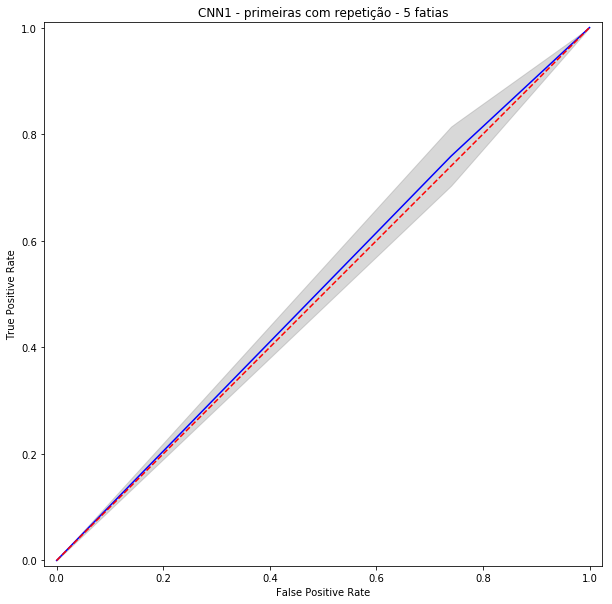

In [13]:
plt.figure(figsize=(10, 10))

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.title("CNN1 - primeiras com repetição - 5 fatias")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.show()